Настя Панасюк, БКЛ182

###### 0. Повторение семинара

In [1]:
import re
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim 

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [286]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

In [287]:
data = df.content.values.tolist()

data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

In [288]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [289]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [290]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [291]:
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [292]:
id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

##### 1. Проба с маллетом, неудача

In [21]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word) 
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
#coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
#coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#print('\nCoherence Score: ', coherence_ldamallet)

CalledProcessError: Command 'C:/Users/mjo/Downloads/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\mjo\AppData\Local\Temp\767636_corpus.txt --output C:\Users\mjo\AppData\Local\Temp\767636_corpus.mallet' returned non-zero exit status 1.

###### Маллет не работает из-за java, скрин

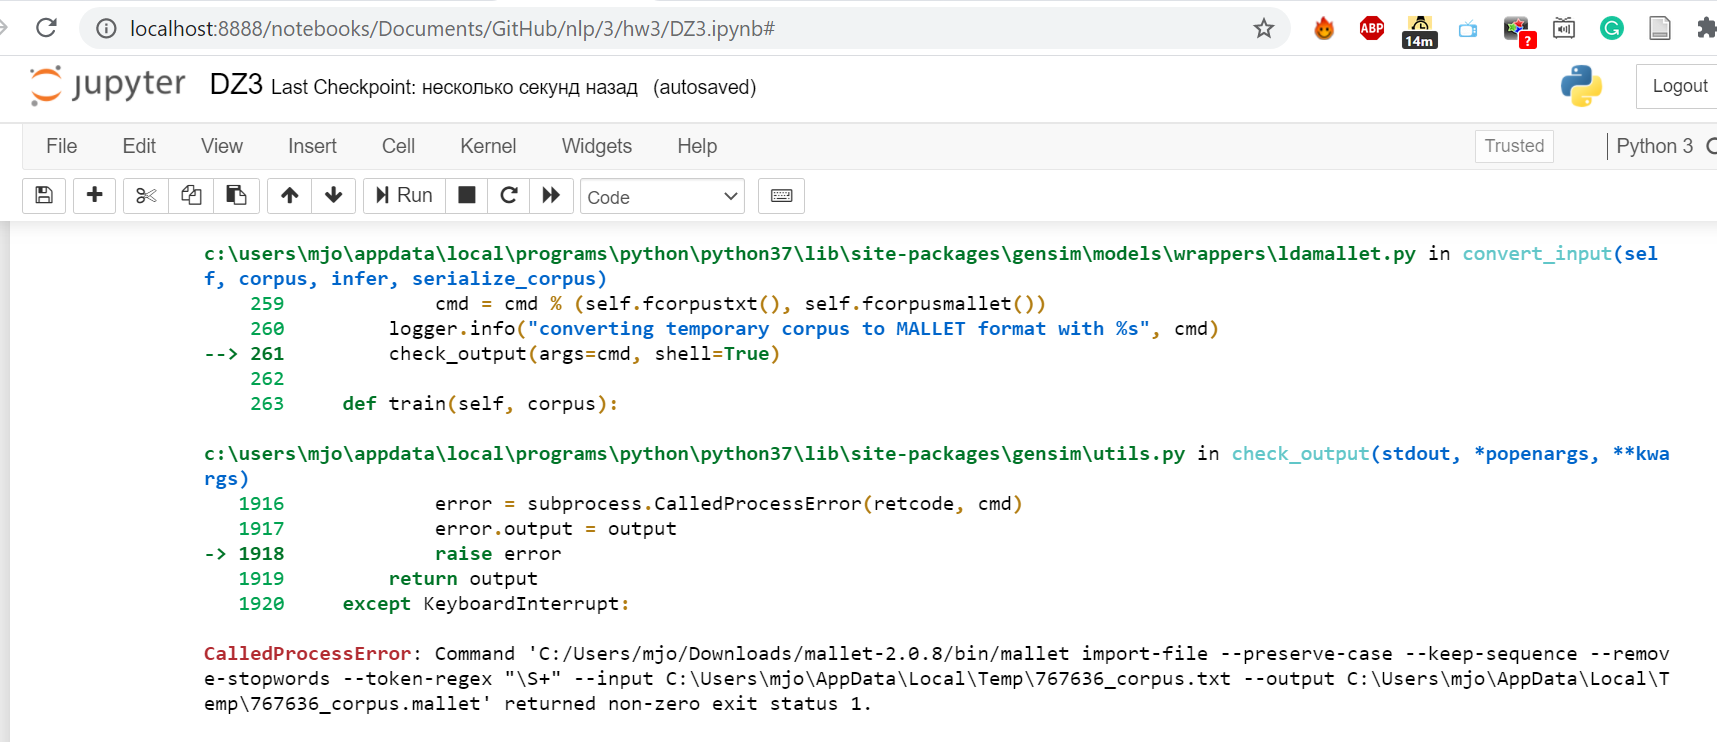

###### 2. Подбор лучшего количества топиков (сразу с прогоном дженсима...)

In [26]:
def bestnum(corpus, texts, id2word, start, limit, step):
    number = []
    coherence = []
    for i in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
       
        number.append(i)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence.append(coherence_model_lda.get_coherence())
        
    return number, coherence

In [27]:
topicnum, coherences = bestnum(corpus, data_lemmatized, id2word, 3, 30, 3)

In [28]:
for i, j in zip(topicnum, coherences):
    print(i,j)

3 0.5100121954105242
6 0.5298558581887968
9 0.529042485995545
12 0.49234154981705197
15 0.499899150378291
18 0.5145455911420842
21 0.517319594611715
24 0.454037383833186
27 0.4576083097479518


Вывод: хорошо делится либо на небольшое количество топиков (3, 6, 9), либо на ~20 (18-21) топиков. Я пробовала взять 9, топики были не очень понятные, взяла 21, топики оказались хорошими. Дальше в тетради код для 21.

In [31]:
lda_21 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=21, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
pprint(lda_21.print_topics())

[(13,
  '0.095*"sorry" + 0.042*"utility" + 0.039*"band" + 0.028*"green" + '
  '0.025*"giant" + 0.021*"glad" + 0.020*"angel" + 0.017*"creature" + '
  '0.015*"dirt" + 0.015*"emphasis"'),
 (4,
  '0.189*"faith" + 0.126*"child" + 0.082*"character" + 0.069*"revelation" + '
  '0.048*"parent" + 0.044*"scripture" + 0.020*"follower" + 0.018*"trivial" + '
  '0.011*"upset" + 0.007*"ceremonial"'),
 (14,
  '0.115*"israeli" + 0.071*"land" + 0.060*"bomb" + 0.038*"northern" + '
  '0.029*"peace" + 0.029*"arab" + 0.028*"icon" + 0.026*"truck" + '
  '0.024*"reflect" + 0.021*"inhabitant"'),
 (17,
  '0.051*"graphic" + 0.048*"soldier" + 0.047*"kill" + 0.043*"village" + '
  '0.039*"attack" + 0.030*"turkish" + 0.027*"murder" + 0.027*"occupy" + '
  '0.024*"armenian" + 0.024*"turk"'),
 (12,
  '0.156*"gun" + 0.070*"fire" + 0.064*"fan" + 0.052*"shoot" + 0.048*"weapon" + '
  '0.036*"firearm" + 0.034*"arm" + 0.033*"cop" + 0.026*"department" + '
  '0.025*"carry"'),
 (7,
  '0.231*"drive" + 0.125*"chip" + 0.060*"bit" + 

По какой-то причине в 6 теме нет слов))))) И самой 6-ой темы нет в списке. В будущем буду избегать прописывать в коде проверки из-за этого.

###### 3. Выбор широкого топика через Counter

Составляю списки с ключевыми словами из топика. NB с маллетом, чтобы он сразу подобрал верный топик, у меня не получилось из-за джава, поэтому не у всех текстов окажется определенным широкий топик. 10 главных слов топика могут не встретиться в тексте, могут встретиться чуть менее ключевые.

In [77]:
#  Составляю списки с номерами топиков и ключевыми словами, по которым буду проверять тексты.

keylist = []
for item in lda_21.print_topics():
    topicnum = item[0]
    topickeys = re.findall('\*\"(\S+)?\"', item[1])
    keylist.append([topicnum, topickeys])

In [79]:
keylist

[[13,
  ['sorry',
   'utility',
   'band',
   'green',
   'giant',
   'glad',
   'angel',
   'creature',
   'dirt',
   'emphasis']],
 [4,
  ['faith',
   'child',
   'character',
   'revelation',
   'parent',
   'scripture',
   'follower',
   'trivial',
   'upset',
   'ceremonial']],
 [14,
  ['israeli',
   'land',
   'bomb',
   'northern',
   'peace',
   'arab',
   'icon',
   'truck',
   'reflect',
   'inhabitant']],
 [17,
  ['graphic',
   'soldier',
   'kill',
   'village',
   'attack',
   'turkish',
   'murder',
   'occupy',
   'armenian',
   'turk']],
 [12,
  ['gun',
   'fire',
   'fan',
   'shoot',
   'weapon',
   'firearm',
   'arm',
   'cop',
   'department',
   'carry']],
 [7,
  ['drive',
   'chip',
   'bit',
   'device',
   'speed',
   'scsi',
   'internal',
   'bus',
   'ide',
   'fast']],
 [5,
  ['com',
   'mouse',
   'doctor',
   'door',
   'frame',
   'production',
   'expansion',
   'double',
   'lock',
   'deliver']],
 [8,
  ['driver',
   'monitor',
   'video',
   'printer

In [115]:
#  функция, которая определяет широкий топик текста через подсчет вхождений 10-и главных слов темы

def getdominanttop(text, topiclist):
    text_dict = defaultdict(int)
    
    for word in text:
        for topic in topiclist:
            topicnum = topic[0]
            if word in topic[1]:
                text_dict[topicnum]+=1
    dominant = Counter(text_dict).most_common(1)    
    if dominant:
        return dominant[0][0]
    else:                    # Прописываю исключение для топиков, у которых не удалось определить широкий топик
        return 'None'  #например, кол-во за топик 6 = кол-во за топик 8 или вообще не встретилось ключевых слов в тексте

Создаю список словарей с информацией о номере текста в датасете и широком топике

In [279]:
data_dicts = []  # список словарей, в который будем все добавлять

for num, text in enumerate(data_lemmatized):
    dom = getdominanttop(text, keylist)
    data_dicts.append({'id': num+1, 'text': data[num], 'dominant': dom})

###### 4. Выделение ключевых слов для каждого текста через TF-IDF

In [236]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)    

In [280]:
for top_num, text_list in enumerate(text_lists):
    topictexts = []
    
    if len(text_list)>1:  # проверка, чтобы не учитывать отчего-то пустую 6-ую тему
        for text in text_lists[top_num][1:]:
            topictexts.append(text[1])
        texts_as_tfidf_vectors = tfidf.fit_transform(topictexts)  # создаю матрицу
        idtwoword = {i:word for i,word in enumerate(tfidf.get_feature_names())} 
        
        for text_id, text_row in enumerate(range(texts_as_tfidf_vectors.shape[0])):  # прохожу по матрице
            
            row_data = texts_as_tfidf_vectors.getrow(text_row) 
            words_for_this_text = row_data.toarray().argsort() 
            top_words_for_this_text = words_for_this_text [0,:-6:-1] 
            keywords = [idtwoword[w] for w in top_words_for_this_text]  # выделяю отличительные слова
            
            numm = text_lists[top_num][text_id+1][0]
            data_dicts[numm-1]['keywords']= ', '.join(keywords)  # добавляю в словарь

In [282]:
data_dicts[0]

{'id': 1,
 'text': 'From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ',
 'dominant': 3,
 'keywords': 'car, door, where, enlighten, funky'}

###### 5. Создаю датафрэйм

In [283]:
df = pd.DataFrame.from_dict(data_dicts)

In [284]:
df

,id,text,dominant,keywords
0,1,From: (wheres my thing) Subject: WHAT car is t...,3,"car, door, where, enlighten, funky"
1,2,From: (Guy Kuo) Subject: SI Clock Poll - Final...,15,"clock, poll, si, final, upgrade"
2,3,From: (Thomas E Willis) Subject: PB questions....,18,"display, machine, disk, bunch, store"
3,4,From: (Joe Green) Subject: Re: Weitek P9000 ? ...,18,"division, weitek, chip, amber, quadrilateral"
4,5,From: (Jonathan McDowell) Subject: Re: Shuttle...,18,"error, bug, warn, memory, waivere"
...,...,...,...,...
11309,11310,From: (Jim Zisfein) Subject: Re: Migraines and...,19,"patient, eeg, dn, tumor, brain"
11310,11311,From: Subject: Screen Death: Mac Plus/512 Line...,7,"blank, screen, sometimes, wire, blanking"
11311,11312,From: (Will Estes) Subject: Mounting CPU Coole...,15,"mount, cpu, cooler, este, weight"
11312,11313,From: (Steven Collins) Subject: Re: Sphere fro...,18,"point, sphere, space, graphics_gem, hyper"


In [285]:
df.to_csv('TopicModellingTFIDF.tsv', sep= '\t')  #сохраняю в tsv информацию, потому что с csv могут быть проблемы с разделителем

###### 6* Бонус: Topic Coherence

Topic Coherence - это метрика, которая измеряет, насколько <i>семантически</i> близки слова с наибольшим весом внутри одного топика.<br>Это помогает различать топики, которые действительно <u>близки семантически</u>, и топики, <u>которые были выделены ввиду необходимости выделить определенное количество топиков</u>. (Условно, говорю: хочу 10 топиков. А столько может не быть, но модель постарается мне найти столько, потому что я приказала найти 10.)

"Когерентность топика": когда высказывания соответствуют друг другу тематически. Т.е. когда словами, которые выделил топик, можно описать совокупность ситуаций в высказывании. (Топ слов "судья, спорт, бег" для топика с текстами про футбол, баскетбол итд)